## Proj Description

## Libraries

In [152]:
library(plyr)

In [153]:
library(dplyr)
#library(plyr)
library(ggplot2)
library(grid)
library(jpeg)
library(RCurl)
library(reshape2)
library(knitr)
library(RColorBrewer)
library(scales)

# Read data


In [154]:
setwd('/Users/zakesk/basketball/zakesk-intern-project')

In [155]:
nba <- read.csv("complete_data.csv") %>% as.data.frame()
players <- read.csv("players.csv") %>% as.data.frame()
teams <- read.csv("teams.csv") %>% as.data.frame()

## ## Drop columns

In [156]:
colnames(nba)

[1] "X"                  "id"                 "season"            
 [4] "game"               "quarter"            "team"              
 [7] "opponent"           "home"               "offense_basket"    
[10] "passer"             "pass_x"             "pass_y"            
[13] "pass_distance"      "recorded_assist"    "pass_shot_clock"   
[16] "pass_game_clock"    "shooter"            "poss_x"            
[19] "poss_y"             "poss_shot_clock"    "poss_game_clock"   
[22] "shot_x"             "shot_y"             "shot_shot_clock"   
[25] "shot_game_clock"    "dribbles"           "distance_travelled"
[28] "defender"           "ndd"                "made"

In [158]:
nba <- nba[, !(colnames(nba) %in% c('X','game','quarter','home','poss_x','poss_y', 'id', 'pass_shot_clock',
                                   'pass_game_clock', 'pass_x', 'pass_y', 'recorded_assist' ))]
colnames(nba)

[1] "season"             "team"               "opponent"          
 [4] "offense_basket"     "passer"             "pass_distance"     
 [7] "shooter"            "poss_shot_clock"    "poss_game_clock"   
[10] "shot_x"             "shot_y"             "shot_shot_clock"   
[13] "shot_game_clock"    "dribbles"           "distance_travelled"
[16] "defender"           "ndd"                "made"

In [159]:
nba_14 <- filter(nba, season == 2014)
dim(nba_14)

nba_15 <- filter(nba, season == 2015)
dim(nba_15)

nba_16 <- filter(nba, season == 2016)
dim(nba_16)

[1] 247378     18

[1] 226784     18

[1] 25838    18

# Based on the number of rows, the 2016 data appers to be incomplete, so we will filter out 2016 data

In [161]:
nba <- filter(nba, season != 2016)
dim(nba)
unique(nba1$season)

[1] 474162     18

[1] 2014 2015

## Initial Plot

## This is part of the filter, need to filter out FT's later

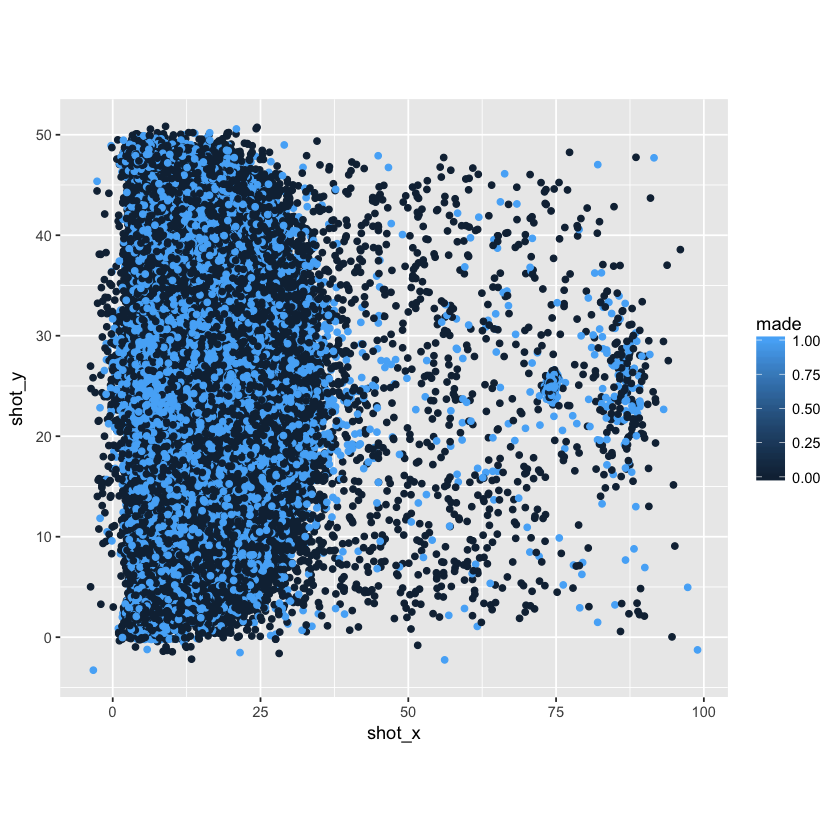

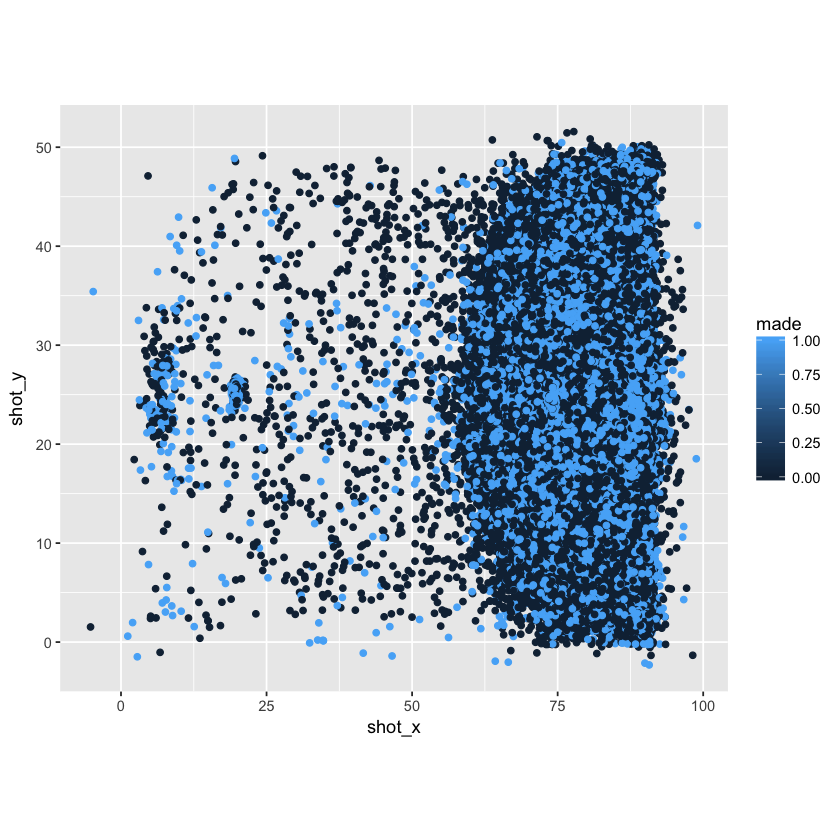

In [172]:
nba_l <- filter(nba, offense_basket == "L")
nba_r <- filter(nba, offense_basket == "R")

ggplot(nba_l, aes(x=shot_x, y=shot_y)) +
         geom_point(aes(colour = made)) +
         coord_fixed(ratio = 1.7)

ggplot(nba_r, aes(x=shot_x, y=shot_y)) +
         geom_point(aes(colour = made)) +
         coord_fixed(ratio = 1.7)

In [173]:
mean(nba$shot_x)

[1] 47.00584

## Midcourt of an NBA court is 47 feet from the baseline, and the mean shot_x coordinate is 47, so this tells me the x coordinates represent the sideline length, and the y coordinates represent the baseline length.  There is appears to be an usually number of made shots beyond halfcourt for both plots.  Perhaps these entries were miscoded?  

In [175]:
nba_radj <- filter(nba, offense_basket == "R") %>% mutate(shot_x = 94 - shot_x, shot_y = 50 - shot_y)
nba1 <- rbind(nba_l, nba_radj)

In [178]:
long_rg <- filter(nba1, shot_x > 47) 

sum(long_rg$made)
length(long_rg$made)
sum(long_rg$made) / length(long_rg$made)

[1] 2476

[1] 4373

[1] 0.5662017

## According to the above calculations, over 56% of shots taken from beyond half court are made.  Something appears to miscoded with that data, so I will exclude it in later steps.

## change NA shot clocks to -1 (used to filter out Free Throws)

## Assign point values, based on distance and shot clock (for FT's), Shot Distance, Flag for Made/Missed, and Shot Zone (explain the FT part)

In [183]:
nba1$shot_shot_clock[is.na(nba1$shot_shot_clock)] <- -1

nba2 <- nba1 %>% 
        #use shot coordinates to determine point value
        mutate(shot_type = ifelse(shot_y < 3 | shot_y > 47 | ((shot_x - 5.25) ^ 2 + (shot_y - 25) ^ 2) > (23.75^ 2),3, 
                               ifelse((shot_shot_clock == 24 | shot_shot_clock == -1) & 
                                   shot_x > 19 & shot_x < 20.3 & shot_y > 23.7 & shot_y < 26.3, 1,2))) %>% 
        # calculate shot distance
        mutate(shot_dist = sqrt((shot_x - 5.25 ) ^ 2 + (shot_y - 25 ) ^ 2)) %>% 
        # add flag for Made/Mised
        mutate(made_or_missed = ifelse(made == 0, "Missed", 
                              ifelse(made == 1, "Made","Undefined"))) %>% 
        # use point value and coordinates to determine shot zone
        mutate(shot_zone = ifelse(shot_type == 3, 
                              ifelse(shot_x > 47, "Beyond_Half_Court",
                                  ifelse(shot_y < 3 & shot_x < 14, "Left_Corner_3",
                                   ifelse(shot_y > 47 & shot_x < 14, "Right_Corner_3", "Top_or_Wing_3"))), 
                           ifelse(shot_type == 1, "FT", 
                           ifelse(shot_type == 2,
                           ifelse ((shot_x - 5.25) ^ 2 + (shot_y - 25) ^ 2 < 4 ^ 2 , "Restricted_Area",
                           ifelse(shot_y > 17 & shot_y < 33,  "Paint","Midrange_2")),"Undefined")))) %>%

        as.data.frame()                         

nba_pt_summary <- ddply(nba2, c("shot_type"), summarise, shots_made = sum(made), att = length(made),
                            pct = shots_made / att )
nba_pt_summary

nba_shot_summary <- ddply(nba2, c("shot_type", "shot_zone"), summarise, shots_made = sum(made), att = length(made),
                            pct = shots_made / att )
nba_shot_summary

shot_type,shots_made,att,pct
1,68841,91593,0.7515967
2,140315,286023,0.4905724
3,35718,96546,0.3699584


shot_type,shot_zone,shots_made,att,pct
1,FT,68841,91593,0.7515967
2,Midrange_2,31490,79490,0.3961505
2,Paint,60167,129538,0.4644737
2,Restricted_Area,48658,76995,0.6319631
3,Beyond_Half_Court,2476,4373,0.5662017
3,Left_Corner_3,4236,11027,0.3841480
3,Right_Corner_3,4862,12477,0.3896770
3,Top_or_Wing_3,24144,68669,0.3515997


## Other than the issue with shots beyond half court, this data looks reasonable.... further description

## 1st plot - Explain the shape, x/y and purpose of this graph

Warning message:
“Removed 191 rows containing missing values (geom_point).”

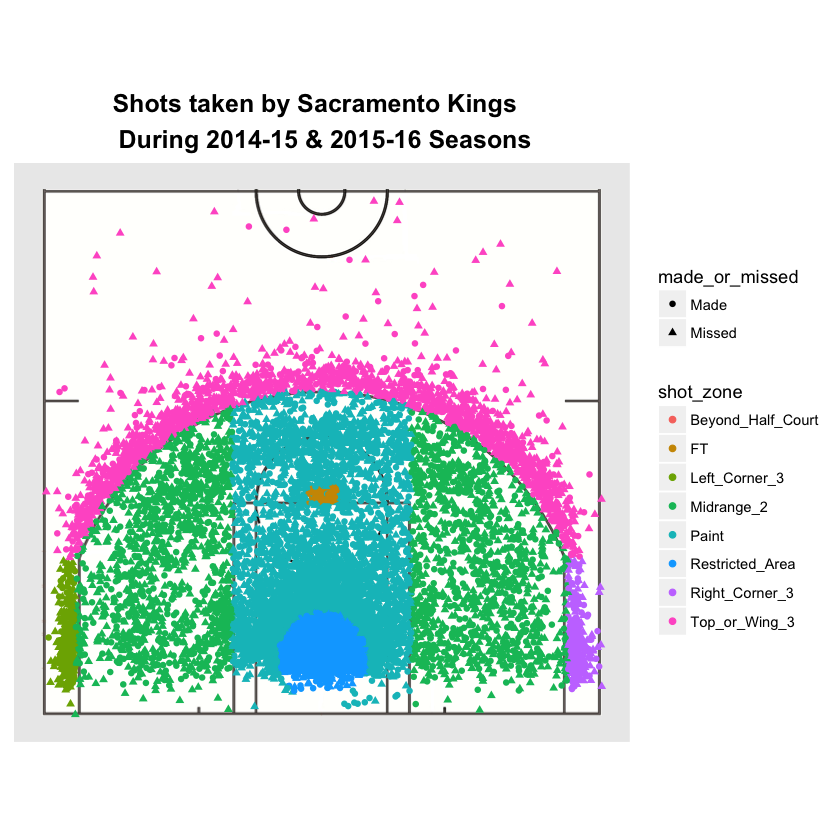

In [201]:
courtImg.URL <- "https://thedatagame.files.wordpress.com/2016/03/nba_court.jpg"
court <- rasterGrob(readJPEG(getURLContent(courtImg.URL)),width=unit(1,"npc"), height=unit(1,"npc"))

ggplot(nba2[nba2$team == 23,], aes(x=shot_y, y=shot_x)) + 
      annotation_custom(court, 0, 50, 0, 47) +
      geom_point(aes(colour = shot_zone, shape = made_or_missed)) +
      xlim(0, 50) +
      ylim(0, 47) +
      coord_fixed(ratio = 1) +
  ggtitle(paste("Shots taken by Sacramento Kings ", "\n", "During 2014-15 & 2015-16 Seasons")) +
  theme(line = element_blank(),
        plot.title = element_text(size = 15, lineheight = 1.2, face = "bold", hjust = 0.5),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank())

# warning message is for shots taken behind the halfcourt line

## Filter out shots beyond half court

In [189]:
nba3 <- filter(nba2, shot_zone != "Beyond_Half_Court") %>% as.data.frame

nba_pt_summary2 <- ddply(nba3, c("shot_type"), summarise, shots_made = sum(made), att = length(made),
                            pct = shots_made / att )
nba_pt_summary2

nba_shot_summary2 <- ddply(nba3, c("shot_type", "shot_zone"), summarise, shots_made = sum(made), att = length(made),
                            pct = shots_made / att )
nba_shot_summary2

shot_type,shots_made,att,pct
1,68841,91593,0.7515967
2,140315,286023,0.4905724
3,33242,92173,0.3606479


shot_type,shot_zone,shots_made,att,pct
1,FT,68841,91593,0.7515967
2,Midrange_2,31490,79490,0.3961505
2,Paint,60167,129538,0.4644737
2,Restricted_Area,48658,76995,0.6319631
3,Left_Corner_3,4236,11027,0.3841480
3,Right_Corner_3,4862,12477,0.3896770
3,Top_or_Wing_3,24144,68669,0.3515997


## Examine wide-open catch and shoot situations (explain why I chose these parameters)

In [199]:
unguarded <- filter(nba3, dribbles < 2, ndd > 4)

unguarded_pt_summary <- ddply(unguarded, c("shot_type"), summarise, shots_made = sum(made), att = length(made),
                            pct = shots_made / att )
unguarded_pt_summary

unguarded_shot_summary <- ddply(unguarded, c("shot_type", "shot_zone"), summarise, shots_made = sum(made), att = length(made),
                            pct = shots_made / att )
unguarded_shot_summary

shot_type,shots_made,att,pct
1,39249,53636,0.7317660
2,33939,64586,0.5254854
3,24166,64276,0.3759724


shot_type,shot_zone,shots_made,att,pct
1,FT,39249,53636,0.7317660
2,Midrange_2,13097,30918,0.4236044
2,Paint,12891,24584,0.5243654
2,Restricted_Area,7951,9084,0.8752752
3,Left_Corner_3,3556,9009,0.3947164
3,Right_Corner_3,3991,9957,0.4008235
3,Top_or_Wing_3,16619,45310,0.3667844


In [200]:
cbind(unguarded_pt_summary$shot_type, round(unguarded_pt_summary$pct - nba_pt_summary2$pct,3))
cbind(unguarded_shot_summary$shot_zone, round(unguarded_shot_summary$pct - nba_shot_summary2$pct,3))

1,-0.020
2,0.035
3,0.015


FT,-0.02
Midrange_2,0.027
Paint,0.06
Restricted_Area,0.243
Left_Corner_3,0.011
Right_Corner_3,0.011
Top_or_Wing_3,0.015


## The above shows that ...... effect of finding an open shooter

## Filter to get wide open shots.... explain why I'm choosing these parameters

In [303]:
nba_wo <- filter(nba2, dribbles < 2, ndd > 4, pass_distance > 5, shot_type != 1, shot_zone != "Beyond_Half_Court")
dim(nba_wo)

[1] 120097     22

## Merge the data from the other csv files based on defender id, passer id, and shooter id

In [304]:
# drop unneeded columns
players[,5:8] <- NULL

# I might not use defense.... keep this here for now
defense <- players
col.d <- c("player_id","def.firstname","def.lastname","def.position")
colnames(defense) <- col.d

passer <- players
col.p <- c("player_id", "pass.firstname","pass.lastname","pass.position")
colnames(passer) <- col.p

shooter <- players
col.s <- c("player_id", "shoot.firstname","shoot.lastname","shoot.position")
colnames(shooter) <- col.s

nba_wo2 <- left_join(nba_wo, defense, by = c("defender" = "player_id")) %>%
               left_join(passer,  by = c("passer" = "player_id")) %>%
               left_join(shooter,  by = c("shooter" = "player_id")) %>%
               as.data.frame

sample_n(nba2,5)

,season,team,opponent,offense_basket,passer,pass_distance,shooter,poss_shot_clock,poss_game_clock,shot_x,⋯,shot_game_clock,dribbles,distance_travelled,defender,ndd,made,shot_type,shot_dist,made_or_missed,shot_zone
16712,2014,4,8,L,263220,14.16424,229569,9.00,615.87,7.41413,⋯,615.07,0,0.000000,253996,2.2000466,1,2,3.739617,Made,Restricted_Area
208438,2015,15,2,L,609790,27.32843,467271,14.33,208.32,8.60324,⋯,207.21,1,4.809837,462461,0.9295284,1,2,3.354458,Made,Restricted_Area
254193,2014,21,22,R,469085,19.14615,469089,16.13,646.03,4.98400,⋯,644.23,0,0.000000,253998,1.1003684,0,2,19.385175,Missed,Midrange_2
320315,2014,20,10,R,467471,17.27413,609790,14.49,657.86,25.38660,⋯,657.10,0,0.000000,332691,3.5804452,0,2,20.932733,Missed,Paint
208286,2015,7,9,L,NA,NA,510954,7.11,192.42,19.78930,⋯,192.00,0,0.000000,303807,6.1186846,1,1,14.560568,Made,FT


## Figure out who to drop

In [305]:
nba_sum_for_drop <- ddply(nba_wo2, c("passer", "pass.lastname", "pass.firstname"), summarise, fg_made = sum(made), 
                 fg_att = length(made)) %>% arrange(fg_att)
dim(nba_sum_for_drop)
summary(nba_sum_for_drop$fg_att)

[1] 562   5

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    36.0   115.0   213.7   288.2  1724.0 

In [306]:
passers_to_drop  <- filter(nba_sum_for_drop, fg_att < 100) 
drop1 <- as.list(passers_to_drop$passer)


In [307]:
# this code would keep the players I want and drop others
nba_filt <- filter(nba_wo2, !(passer %in% drop1))
length(unique(nba_filt$passer))

[1] 301

## Create summary by shot_zone for players

In [308]:
nba_sum <- ddply(nba_filt, c("pass.position","pass.lastname", "pass.firstname", "shot_zone"), summarise, fg_made = sum(made), 
                 fg_att = length(made))

## Add in calculation for 2/3 pointers, verify the two data frames are  identically arranged

In [309]:
pos_sum_made = dcast(nba_sum, pass.position ~ shot_zone, value.var = "fg_made", fun.aggregate = sum, 
  na.rm = TRUE) %>% mutate(two_ptrs = Midrange_2 + Paint + Restricted_Area, three_ptrs = Top_or_Wing_3 +
                           Left_Corner_3 + Right_Corner_3, all_fgs = two_ptrs + three_ptrs) %>% as.data.frame

pos_sum_taken = dcast(nba_sum, pass.position ~ shot_zone, value.var = "fg_att", fun.aggregate = sum, 
  na.rm = TRUE) %>% mutate(two_ptrs = Midrange_2 + Paint + Restricted_Area, three_ptrs = Top_or_Wing_3 +
                           Left_Corner_3 + Right_Corner_3, all_fgs = two_ptrs + three_ptrs) %>% as.data.frame

# verifies the two data frame are identically arranged
identical(dim(pos_sum_made),dim(pos_sum_taken))
identical(dim(pos_sum_made$pass.position), dim(pos_sum_taken$pass.position))
identical(colnames(pos_sum_made), colnames(pos_sum_taken))

[1] TRUE

[1] TRUE

[1] TRUE

## Calculate shooting percentage by position, shot_zone and type

In [311]:
# divide the 2 data frames
pos_sum_pct <- round(pos_sum_made[,c(2:dim(pos_sum_made)[2])] / 
                    pos_sum_taken[,c(2:dim(pos_sum_taken)[2])],3)

# cbind to add position name back in
pos_sum <- cbind(pos_sum_pct, pos_sum_taken$pass.position )  

# rename column to eliminate the long name
colnames(pos_sum)[which(names(pos_sum) == "pos_sum_taken$pass.position")] <- "pass.position"

# rearrange the columns
pos_sum <- pos_sum %>%  select(pass.position, everything()) 

# change passer NA's to 0
pos_sum[,2:10][is.na(pos_sum[,2:10])] <- 0

pos_sum <- as.data.frame(pos_sum)

In [312]:
pos_sum

pass.position,Left_Corner_3,Midrange_2,Paint,Restricted_Area,Right_Corner_3,Top_or_Wing_3,two_ptrs,three_ptrs,all_fgs
Center,0.389,0.395,0.498,0.878,0.386,0.390,0.506,0.389,0.443
Forward,0.409,0.449,0.537,0.916,0.384,0.352,0.552,0.366,0.448
Forward-Center,0.400,0.436,0.540,0.873,0.428,0.377,0.548,0.388,0.454
Guard,0.404,0.429,0.506,0.897,0.393,0.367,0.511,0.376,0.444
Guard-Forward,0.399,0.426,0.542,0.910,0.410,0.371,0.528,0.382,0.451
Point Guard,0.380,0.424,0.490,0.892,0.398,0.360,0.501,0.369,0.437
Power Forward,0.440,0.385,0.579,0.876,0.448,0.374,0.544,0.395,0.456
Shooting Guard,0.455,0.437,0.525,0.910,0.375,0.364,0.521,0.380,0.456
Small Forward,0.415,0.437,0.554,0.895,0.408,0.373,0.536,0.384,0.459


## Calculate shooting percentage by position, shot_zone and type

In [313]:
pl_sum_made = dcast(nba_sum, pass.lastname + pass.firstname + pass.position ~ shot_zone, 
                    value.var = "fg_made", fun.aggregate = sum, na.rm = TRUE) %>% 
              mutate(two_ptrs = Midrange_2 + Paint + Restricted_Area, three_ptrs = Top_or_Wing_3 +
                           Left_Corner_3 + Right_Corner_3, all_fgs = two_ptrs + three_ptrs) %>% as.data.frame

pl_sum_taken = dcast(nba_sum, pass.lastname + pass.firstname + pass.position ~ shot_zone, 
                    value.var = "fg_att", fun.aggregate = sum, na.rm = TRUE) %>% 
              mutate(two_ptrs = Midrange_2 + Paint + Restricted_Area, three_ptrs = Top_or_Wing_3 +
                           Left_Corner_3 + Right_Corner_3, all_fgs = two_ptrs + three_ptrs) %>% as.data.frame

# # verifies the two data frame are identically arranged
identical(dim(pl_sum_made),dim(pl_sum_taken))
identical(pl_sum_made$pass.lastname, pl_sum_taken$pass.lastname)
identical(pl_sum_made$pass.firstname, pl_sum_taken$pass.firstname)
identical(colnames(pl_sum_made), colnames(pl_sum_taken))

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

## Divide the two data frames to calculate shooting percentage by shot_zone and type

In [315]:
# divide the 2 data frames
pl_sum_pct <- round(pl_sum_made[,c(4:dim(pl_sum_made)[2])] / 
                    pl_sum_taken[,c(4:dim(pl_sum_taken)[2])],3)

# cbind to add player name back in
pl_sum <- cbind(pl_sum_pct, pl_sum_taken$pass.lastname, pl_sum_taken$pass.firstname, pl_sum_taken$pass.position )  

# rename columns to eliminate the long name
colnames(pl_sum)[which(names(pl_sum) == "pl_sum_taken$pass.position")] <- "pass.position"
colnames(pl_sum)[which(names(pl_sum) == "pl_sum_taken$pass.lastname")] <- "pass.lastname"
colnames(pl_sum)[which(names(pl_sum) == "pl_sum_taken$pass.firstname")] <- "pass.firstname"

# rearrange the columns
pl_sum <- pl_sum %>%  select(pass.lastname, pass.firstname, pass.position, everything()) 

# change passer NA's to 0
pl_sum[,4:12][is.na(pl_sum[,4:12])] <- 0

pl_sum <- as.data.frame(pl_sum)

## Rename columns

In [317]:
pos_sum2 <- pos_sum

colnames(pos_sum2) <- c('position','lg_avg_Left_Corner_3',
  'lg_avg_Midrange_2', 'lg_avg_Paint', 'lg_avg_Restricted_Area', 'lg_avg_Right_Corner_3',
  'lg_avg_Top_or_Wing_3', 'lg_avg_two_ptrs', 'lg_avg_three_ptrs', 'lg_avg_all_fgs')

## Join tables to calculate the summary of shooting % vs league avg at position

In [318]:
# inner join to bring in positional data
sum_vs_avg <- inner_join(pl_sum, pos_sum2, by= c("pass.position" ="position"))

# compute the summary vs the positional average
sum_vs_avg <- mutate( sum_vs_avg,  vs_lg_avg_all_fgs = all_fgs - lg_avg_all_fgs,
                    vs_lg_avg_two = two_ptrs - lg_avg_two_ptrs,
                    vs_lg_avg_three = three_ptrs - lg_avg_three_ptrs,
                    #vs_lg_avg_Beyond_Half_Court = Beyond_Half_Court - lg_avg_Beyond_Half_Ct,
                    vs_lg_avg_Left_Corner_3 = Left_Corner_3 - lg_avg_Left_Corner_3,
                    vs_lg_avg_Midrange_2 = Midrange_2 - lg_avg_Midrange_2,
                    vs_lg_avg_Paint = Paint - lg_avg_Paint,
                    vs_lg_avg_Restricted_Area = Restricted_Area - lg_avg_Restricted_Area,
                    vs_lg_avg_Right_Corner_3 = Right_Corner_3 - lg_avg_Right_Corner_3,
                    vs_lg_avg_Top_or_Wing_3 = Top_or_Wing_3 - lg_avg_Top_or_Wing_3)

# cbind to bring in the fg percentage for all shots
sum_vs_avg <- cbind(sum_vs_avg, pl_sum_taken$all_fgs)

# change column name to shorter name
colnames(sum_vs_avg)[which(names(sum_vs_avg) == "pl_sum_taken$all_fgs")] <- "num_of_fg_attempts"

head(sum_vs_avg)


pass.lastname,pass.firstname,pass.position,Left_Corner_3,Midrange_2,Paint,Restricted_Area,Right_Corner_3,Top_or_Wing_3,two_ptrs,⋯,vs_lg_avg_all_fgs,vs_lg_avg_two,vs_lg_avg_three,vs_lg_avg_Left_Corner_3,vs_lg_avg_Midrange_2,vs_lg_avg_Paint,vs_lg_avg_Restricted_Area,vs_lg_avg_Right_Corner_3,vs_lg_avg_Top_or_Wing_3,num_of_fg_attempts
Acy,Quincy,Power Forward,0.667,0.395,0.545,0.857,0.667,0.362,0.493,⋯,-0.006,-0.051,0.001,0.227,0.010,-0.034,-0.019,0.219,-0.012,120
Adams,Steven,Center,0.500,0.440,0.571,1.000,0.250,0.411,0.545,⋯,0.013,0.039,0.011,0.111,0.045,0.073,0.122,-0.136,0.021,114
Afflalo,Arron,Guard-Forward,0.390,0.405,0.464,0.917,0.333,0.330,0.470,⋯,-0.048,-0.058,-0.043,-0.009,-0.021,-0.078,0.007,-0.077,-0.041,549
Aldridge,LaMarcus,Forward-Center,0.300,0.340,0.562,0.750,0.533,0.317,0.452,⋯,-0.075,-0.096,-0.031,-0.100,-0.096,0.022,-0.123,0.105,-0.060,401
Allen,Lavoy,Forward-Center,0.000,0.520,0.500,1.000,0.250,0.400,0.578,⋯,-0.016,0.030,-0.023,-0.400,0.084,-0.040,0.127,-0.178,0.023,130
Allen,Ray,Shooting Guard,0.636,0.394,0.842,1.000,0.577,0.441,0.635,⋯,0.097,0.114,0.120,0.181,-0.043,0.317,0.090,0.202,0.077,159


## Boxplot

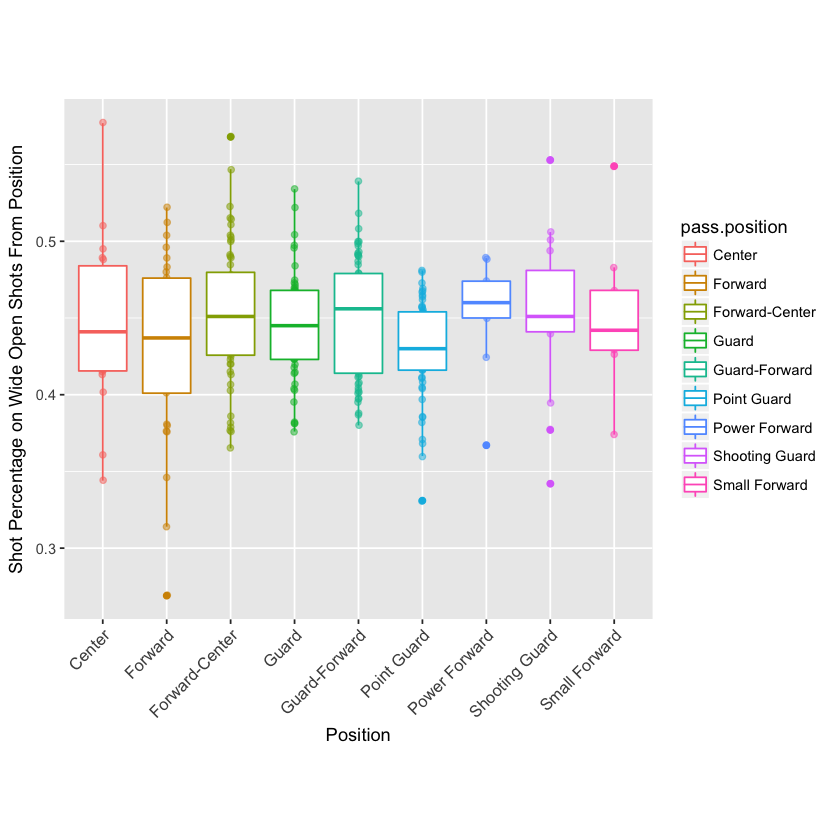

In [339]:
bp <- ggplot(sum_vs_avg, aes(x=pass.position , y=all_fgs)) 
bp + 
  geom_jitter(aes(color = pass.position, x = pass.position), 
              position = position_jitter(width = .01), alpha = 0.5) +
  geom_boxplot(aes(color = pass.position)) +
  xlab("Position") + ylab("Shot Percentage on Wide Open Shots From Position") +
  coord_fixed(ratio = 24) +
  theme(axis.text.x=element_text(size=10,angle=45, hjust=1))

## Compile neccessary info for the players comparison to positional average

In [320]:
pl_avg_summary <- select(sum_vs_avg, pass.lastname, pass.firstname, pass.position, 
                  num_of_fg_attempts, all_fgs, vs_lg_avg_all_fgs, vs_lg_avg_two, vs_lg_avg_three )

In [321]:
# filter player table by number of eligible passes > 100, arranges in descending order and renames columns

calc <- function(x) {
    filter(pl_avg_summary, pass.position == x, num_of_fg_attempts   > 100) %>% 
               arrange(desc(vs_lg_avg_all_fgs )) %>% plyr::rename(c("pass.lastname" = "Last Name", 
                          "pass.firstname" = "First Name", "pass.position" = "Position",
                          "num_of_fg_attempts" = "# of Passes > 5ft. from Player that led to Wide Open FG Attempts",
                          "all_fgs" = "Percentage Shooting on Wide Open Shots From Passer", 
                          "vs_lg_avg_all_fgs" = "Comparison to League Avg FG% at Position",
                          "vs_lg_avg_two" = "Comparison to League Avg FG% for 2's",
                          "vs_lg_avg_three" = "Comparison to League Avg FG% for 3's"))
 }

# change formatting to percentage
cleanup <- function(y) { 
    y[,5] <- scales::percent(y[,5])
    y[,6] <- scales::percent(y[,6])
    y[,7] <- scales::percent(y[,7])
    y[,8] <- scales::percent(y[,8])
    
    return(y)
}    

unique(sum_vs_avg$pass.position)

[1] Power Forward  Center         Guard-Forward  Forward-Center Shooting Guard
[6] Small Forward  Forward        Point Guard    Guard         
9 Levels: Center Forward Forward-Center Guard Guard-Forward ... Small Forward

In [322]:
# create table for each position by running the above function
pf_table <- calc(unique(sum_vs_avg$pass.position)[1]) %>% cleanup()
c_table <- calc(unique(sum_vs_avg$pass.position)[2]) %>% cleanup()
gf_table <- calc(unique(sum_vs_avg$pass.position)[3]) %>% cleanup()
fc_table <- calc(unique(sum_vs_avg$pass.position)[4]) %>% cleanup()
sg_table <- calc(unique(sum_vs_avg$pass.position)[5]) %>% cleanup()
sf_table <- calc(unique(sum_vs_avg$pass.position)[6]) %>% cleanup()
f_table <- calc(unique(sum_vs_avg$pass.position)[7]) %>% cleanup()
pg_table <- calc(unique(sum_vs_avg$pass.position)[8]) %>% cleanup()
g_table <- calc(unique(sum_vs_avg$pass.position)[9]) %>% cleanup()

## Below are tables that show......

In [323]:
paste('Displayed below are the top 8 players at', unique(pf_table$Position), 'out of', dim(pf_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(pf_table, 8)

[1] "Displayed below are the top 8 players at Power Forward out of 9 with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Last Name,First Name,Position,# of Passes > 5ft. from Player that led to Wide Open FG Attempts,Percentage Shooting on Wide Open Shots From Passer,Comparison to League Avg FG% at Position,Comparison to League Avg FG% for 2's,Comparison to League Avg FG% for 3's
Faried,Kenneth,Power Forward,182,48.9%,3.3%,9.8%,0.5%
Scott,Mike,Power Forward,172,48.8%,3.2%,6.9%,2.3%
Kelly,Ryan,Power Forward,190,47.4%,1.8%,-6.9%,7.8%
West,David,Power Forward,448,46.7%,1.1%,4.7%,-1.7%
Morris,Marcus,Power Forward,239,46.0%,0.4%,-1.1%,-1.0%
Cunningham,Dante,Power Forward,148,45.9%,0.3%,-0.3%,0.7%
Acy,Quincy,Power Forward,120,45.0%,-0.6%,-5.1%,0.1%
Booker,Trevor,Power Forward,203,42.4%,-3.2%,-2.7%,-1.0%


In [324]:
paste('Displayed below are the top 8 players at', unique(c_table$Position), 'out of', dim(c_table)[1], 
'with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(c_table, 8)

[1] "Displayed below are the top 8 players at Center out of 19 with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Last Name,First Name,Position,# of Passes > 5ft. from Player that led to Wide Open FG Attempts,Percentage Shooting on Wide Open Shots From Passer,Comparison to League Avg FG% at Position,Comparison to League Avg FG% for 2's,Comparison to League Avg FG% for 3's
Jordan,DeAndre,Center,111,57.7%,13.4%,11.5%,13.9%
Perkins,Kendrick,Center,102,51.0%,6.7%,7.9%,4.0%
Mozgov,Timofey,Center,105,49.5%,5.2%,2.7%,7.8%
Olynyk,Kelly,Center,223,48.9%,4.6%,8.7%,-0.7%
Splitter,Tiago,Center,127,48.8%,4.5%,2.6%,5.7%
Pachulia,Zaza,Center,221,48.0%,3.7%,0.5%,3.6%
Adams,Steven,Center,114,45.6%,1.3%,3.9%,1.1%
Gortat,Marcin,Center,236,45.3%,1.0%,-0.6%,2.8%


In [325]:
paste('Displayed below are the top 8 players at', unique(gf_table$Position), 'out of', dim(gf_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(gf_table, 8)

[1] "Displayed below are the top 8 players at Guard-Forward out of 57 with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Last Name,First Name,Position,# of Passes > 5ft. from Player that led to Wide Open FG Attempts,Percentage Shooting on Wide Open Shots From Passer,Comparison to League Avg FG% at Position,Comparison to League Avg FG% for 2's,Comparison to League Avg FG% for 3's
Thompson,Klay,Guard-Forward,345,53.9%,8.8%,7.3%,9.1%
Carter,Vince,Guard-Forward,272,51.8%,6.7%,10.5%,-2.2%
Webster,Martell,Guard-Forward,124,50.8%,5.7%,0.5%,8.7%
Antetokounmpo,Giannis,Guard-Forward,364,50.0%,4.9%,4.6%,3.8%
Ginobili,Manu,Guard-Forward,532,50.0%,4.9%,11.3%,1.6%
Batum,Nicolas,Guard-Forward,821,49.9%,4.8%,5.4%,0.8%
Allen,Tony,Guard-Forward,163,49.7%,4.6%,1.8%,-1.8%
Iguodala,Andre,Guard-Forward,422,49.3%,4.2%,-1.2%,9.8%


In [326]:
paste('Displayed below are the top 8 players at', unique(fc_table$Position), 'out of', dim(fc_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(fc_table, 8)

[1] "Displayed below are the top 8 players at Forward-Center out of 56 with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Last Name,First Name,Position,# of Passes > 5ft. from Player that led to Wide Open FG Attempts,Percentage Shooting on Wide Open Shots From Passer,Comparison to League Avg FG% at Position,Comparison to League Avg FG% for 2's,Comparison to League Avg FG% for 3's
Davis,Anthony,Forward-Center,222,56.8%,11.4%,6.6%,14.9%
Henson,John,Forward-Center,137,54.7%,9.3%,5.8%,9.7%
Johnson,Amir,Forward-Center,176,52.3%,6.9%,4.8%,5.1%
Duncan,Tim,Forward-Center,309,51.5%,6.1%,9.8%,1.2%
Garnett,Kevin,Forward-Center,138,51.4%,6.0%,9.4%,0.6%
Horford,Al,Forward-Center,319,51.1%,5.7%,1.9%,8.9%
Lee,David,Forward-Center,244,50.4%,5.0%,6.6%,5.9%
Howard,Dwight,Forward-Center,193,50.3%,4.9%,9.7%,4.7%


In [327]:
paste('Displayed below are the top 8 players at', unique(sg_table$Position), 'out of', dim(sg_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(sg_table, 8)

[1] "Displayed below are the top 8 players at Shooting Guard out of 15 with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Last Name,First Name,Position,# of Passes > 5ft. from Player that led to Wide Open FG Attempts,Percentage Shooting on Wide Open Shots From Passer,Comparison to League Avg FG% at Position,Comparison to League Avg FG% for 2's,Comparison to League Avg FG% for 3's
Allen,Ray,Shooting Guard,159,55.3%,9.7%,11.4%,12.0%
McLemore,Ben,Shooting Guard,231,50.6%,5.0%,3.5%,1.4%
Beal,Bradley,Shooting Guard,503,50.1%,4.5%,0.6%,7.1%
Caldwell-Pope,Kentavious,Shooting Guard,168,49.4%,3.8%,6.9%,2.0%
Gordon,Eric,Shooting Guard,470,46.8%,1.2%,0.9%,-0.8%
Green,Willie,Shooting Guard,179,46.4%,0.8%,-2.7%,5.9%
Waiters,Dion,Shooting Guard,398,45.2%,-0.4%,-0.4%,2.1%
Ellington,Wayne,Shooting Guard,142,45.1%,-0.5%,-0.3%,-2.9%


In [328]:
paste('Displayed below are the top 8 players at', unique(sf_table$Position), 'out of', dim(sf_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(sf_table, 8)

[1] "Displayed below are the top 8 players at Small Forward out of 9 with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Last Name,First Name,Position,# of Passes > 5ft. from Player that led to Wide Open FG Attempts,Percentage Shooting on Wide Open Shots From Passer,Comparison to League Avg FG% at Position,Comparison to League Avg FG% for 2's,Comparison to League Avg FG% for 3's
Barnes,Matt,Small Forward,237,54.9%,9.0%,8.0%,5.6%
Hill,Solomon,Small Forward,232,48.3%,2.4%,1.2%,3.5%
Green,Draymond,Small Forward,419,46.8%,0.9%,4.7%,1.9%
Casspi,Omri,Small Forward,199,46.2%,0.3%,-0.4%,1.6%
Jefferson,Richard,Small Forward,242,44.2%,-1.7%,-1.7%,-3.0%
Harkless,Maurice,Small Forward,134,44.0%,-1.9%,-1.9%,-8.6%
Butler,Caron,Small Forward,163,42.9%,-3.0%,-7.3%,2.2%
Aminu,Al-Farouq,Small Forward,197,42.6%,-3.3%,-4.1%,-3.0%


In [329]:
paste('Displayed below are the top 8 players at', unique(pg_table$Position), 'out of', dim(pg_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(pg_table, 8)

[1] "Displayed below are the top 8 players at Point Guard out of 53 with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Last Name,First Name,Position,# of Passes > 5ft. from Player that led to Wide Open FG Attempts,Percentage Shooting on Wide Open Shots From Passer,Comparison to League Avg FG% at Position,Comparison to League Avg FG% for 2's,Comparison to League Avg FG% for 3's
Marshall,Kendall,Point Guard,501,48.1%,4.4%,3.4%,4.7%
Rondo,Rajon,Point Guard,929,48.0%,4.3%,6.7%,2.1%
Holiday,Jrue,Point Guard,560,47.3%,3.6%,4.9%,1.6%
Lowry,Kyle,Point Guard,904,46.9%,3.2%,5.1%,2.0%
Mack,Shelvin,Point Guard,526,46.8%,3.1%,4.5%,2.1%
Lillard,Damian,Point Guard,1333,46.7%,3.0%,2.0%,3.5%
Westbrook,Russell,Point Guard,840,46.5%,2.8%,5.9%,0.6%
Joseph,Cory,Point Guard,347,46.4%,2.7%,2.8%,5.2%


In [330]:
paste('Displayed below are the top 8 players at', unique(g_table$Position), 'out of', dim(g_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(g_table, 8)

[1] "Displayed below are the top 8 players at Guard out of 52 with at least 100 passes of 5 feet or more that lead to a wide open FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Last Name,First Name,Position,# of Passes > 5ft. from Player that led to Wide Open FG Attempts,Percentage Shooting on Wide Open Shots From Passer,Comparison to League Avg FG% at Position,Comparison to League Avg FG% for 2's,Comparison to League Avg FG% for 3's
McCollum,C.J.,Guard,116,53.4%,9.0%,12.1%,6.5%
Galloway,Langston,Guard,182,52.2%,7.8%,2.6%,11.6%
Douglas,Toney,Guard,127,50.4%,6.0%,1.3%,10.8%
Felton,Raymond,Guard,543,49.7%,5.3%,6.1%,6.4%
Miller,Andre,Guard,448,49.6%,5.2%,4.3%,5.2%
Robinson,Nate,Guard,213,48.4%,4.0%,6.2%,-0.1%
Ellis,Monta,Guard,920,47.5%,3.1%,7.5%,2.5%
Vasquez,Greivis,Guard,645,47.3%,2.9%,4.5%,0.4%


## Function to create graph that shows shooting % by zone on court

In [331]:
graph_player <- function(a,b){

# get shot set for selected player
shot_set <- filter(nba_filt, !shot_zone %in% c("FT", "Beyond_Half_Court"), pass.firstname == a,
                   pass.lastname == b)
# summarise shot data
library(plyr)
shot <- ddply(shot_set, .(shot_zone), summarize, 
        SHOTS_ATTEMPTED = length(made),
        SHOTS_MADE = sum(as.numeric(as.character(made))))
     
# calculate shot zone accuracy and add zone accuracy labels
shot$SHOT_ACCURACY <- (shot$SHOTS_MADE / shot$SHOTS_ATTEMPTED)
shot$SHOT_ACCURACY_LAB <- paste(as.character(round(100 * shot$SHOT_ACCURACY, 1)), "%", sep="")

# gets positional average data
pos_zone <- filter(pos_sum, 
                   pass.position == unique(shot_set$pass.position)[1]) %>% melt(id.vars = "pass.position") %>%
                   plyr::rename(c("variable" = "shot_zone", "value" = "lg_avg")) %>%
                   filter(!shot_zone %in% c("FT", "Beyond_Half_Court")) %>% mutate(ms_x = c(7,21,15,7,7,31,32,33,35),
                   ms_y = c(2,25,25,25,48,25,27,27,27))

# gets player summary data
player_ds <- filter(pl_avg_summary, pass.firstname == a, pass.lastname == b)

pl_all_fgs <- scales::percent(as.numeric (player_ds[5]))
pl_all_vs_avg <- scales::percent(as.numeric (player_ds[6]))

pl_2_total <- scales::percent(pos_zone[7,3] + as.numeric (player_ds[7]))
pl_3_total <- scales::percent(pos_zone[8,3] + as.numeric (player_ds[8]))    

# join with league average and gets in coordinates for graph
shot <- left_join(shot, pos_zone[,c("shot_zone","lg_avg","ms_x","ms_y")], by = "shot_zone" ) %>% 
         as.data.frame() 

#create plot    
ggplot(shot, aes(x=ms_y, y=ms_x)) +
scale_color_brewer(palette = "Dark2", type="qual", name = "Shot Accuracy by location on floor") +
    annotation_custom(court, 0, 50, 0, 47) +
    geom_point(aes(col = shot_zone), size = 7) +
    geom_text(aes(col = shot_zone, label = SHOT_ACCURACY_LAB), vjust = -1.2, size = 6) +
   guides(colour = guide_legend(order = 1)) +
    xlim(0, 50) +
    ylim(0, 47) +
    coord_fixed(ratio = .7) +
    ggtitle(paste("Wide Open Shot Accuracy From Passes by Player\n", a," ", b, " - ",pos_zone$pass.position, 
                  "\n", "Shot Accuracy - Total FG's: ",pl_all_fgs,
                  "\n", "Shot Accuracy - 2 Point FG's: ",pl_2_total,
                  "\n", "Shot Accuracy - 3 Point FG's: ",pl_3_total,sep = "")) +
    theme(line = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        legend.position = c(0.77, 0.74),   
        legend.title = element_text(size=11),
        legend.text=element_text(size = 12),
        plot.title = element_text(size = 13, lineheight = 1.2, face = "bold", hjust = 0.5))
}

## Function to create graph to compare against league avg at position

In [332]:
graph_player_vs_lg <- function(a,b){

# get shot set for selected player
shot_set <- filter(nba_filt, !shot_zone %in% c("FT", "Beyond_Half_Court"), pass.firstname == a,
                   pass.lastname == b)

# summarise shot data
library(plyr)
shot <- ddply(shot_set, .(shot_zone), summarize, 
        SHOTS_ATTEMPTED = length(made),
        SHOTS_MADE = sum(as.numeric(as.character(made))))
        

# calculate shot zone accuracy and add zone accuracy labels
shot$SHOT_ACCURACY <- (shot$SHOTS_MADE / shot$SHOTS_ATTEMPTED)
shot$SHOT_ACCURACY_LAB <- paste(as.character(round(100 * shot$SHOT_ACCURACY, 1)), "%", sep="")



# gets league average data for player's position
pos_zone <- filter(pos_sum, 
                   pass.position == unique(shot_set$pass.position)[1]) %>% melt(id.vars = "pass.position") %>%
                   plyr::rename(c("variable" = "shot_zone", "value" = "lg_avg")) %>%
                   filter(!shot_zone %in% c("FT", "Beyond_Half_Court")) %>% mutate(ms_x = c(7,21,15,7,7,31,32,33,35),
                   ms_y = c(2,25,25,25,48,25,27,27,27))

# gets data on specific player
player_ds <- filter(pl_avg_summary, pass.firstname == a, pass.lastname == b)

# extracts player data    
pl_all_fgs <- scales::percent(as.numeric (player_ds[5]))
pl_all_vs_avg <- scales::percent(as.numeric (player_ds[6]))

pl_all_2vs_avg <- scales::percent(as.numeric (player_ds[7]))
pl_all_3vs_avg <- scales::percent(as.numeric (player_ds[8]))

pl_2_total <- scales::percent(pos_zone[7,3] + as.numeric (player_ds[7]))
pl_3_total <- scales::percent(pos_zone[8,3] + as.numeric (player_ds[8]))

    
    
# join with league average and compute difference
shot <- left_join(shot, pos_zone[,c("shot_zone","lg_avg","ms_x","ms_y")], by = "shot_zone" ) %>% 
         mutate(VS_LG_AVG = SHOT_ACCURACY - lg_avg,
                VS_LG_AVG_LAB = paste(as.character(round(100 * VS_LG_AVG, 1)), "%", sep="")) %>%
         as.data.frame() 

# sets default color scale
clr_bound <- max(abs(shot$VS_LG_AVG))
grad_lim <- .20

# changes the color scale if there is a large value on shot chart    
if(clr_bound > grad_lim) {grad_lim = round(clr_bound +.05 ,1) }
grad_limits <- c(-grad_lim, grad_lim)

myPalette <- colorRampPalette(rev(brewer.pal(11, "RdBu")))

# plots data
ggplot(shot, aes(x=ms_y, y=ms_x)) +
    scale_colour_gradientn(colours = myPalette(100), limits=grad_limits, labels = percent, 
                           name = "Comparison to Leage\nAverage at position") +
    annotation_custom(court, 0, 50, 0, 47) +
    geom_point(aes(col = VS_LG_AVG), size = 7) +
    geom_text(aes(col = VS_LG_AVG, label = VS_LG_AVG_LAB), vjust = -1.2, size = 6) +
   guides(alpha = FALSE, size = FALSE) +
    xlim(0, 50) +
    ylim(0, 47) +
    coord_fixed(ratio = .7) +
    ggtitle(paste("Wide Open Shot Accuracy From Passes by Player\n", a," ", b, " - ",pos_zone$pass.position, 
                  "\n", "Shot Accuracy compared to League Avg - Total FG's: ", pl_all_vs_avg,
                  "\n", "Shot Accuracy compared to League Avg - 2 Point FG's: ", pl_all_2vs_avg,
                  "\n", "Shot Accuracy compared to League Avg - 3 Point FG's: ", pl_all_3vs_avg,sep = "")) +
    theme(line = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        legend.position = c(0.81, 0.75),   
        legend.title = element_text(size=11),
        legend.text=element_text(size = 12),
        plot.title = element_text(size = 13, lineheight = 1.2, face = "bold", hjust = 0.5))
}    

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

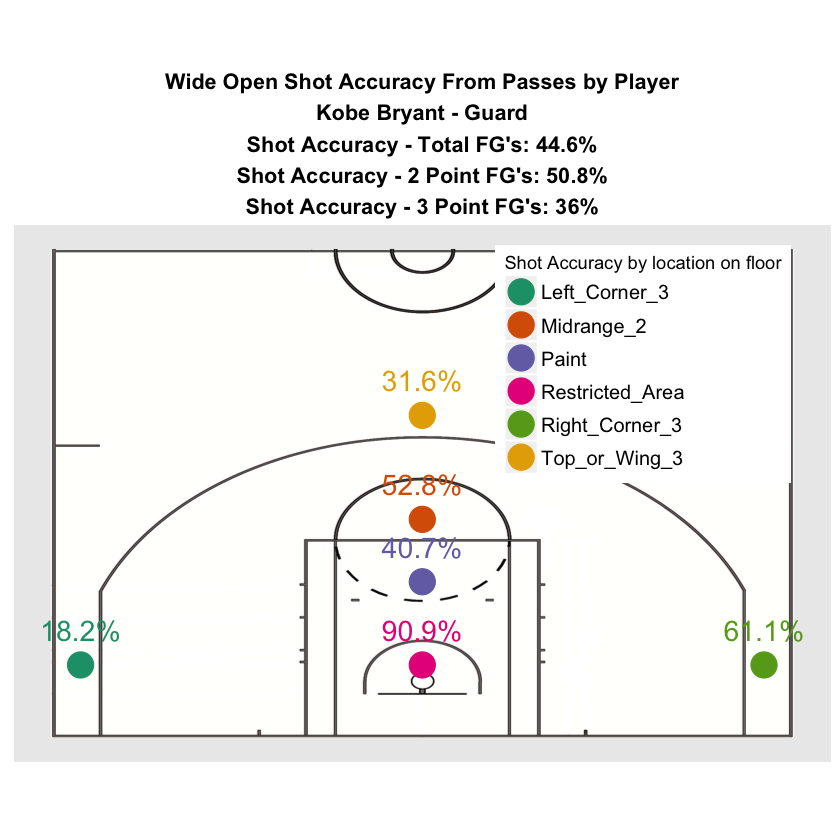

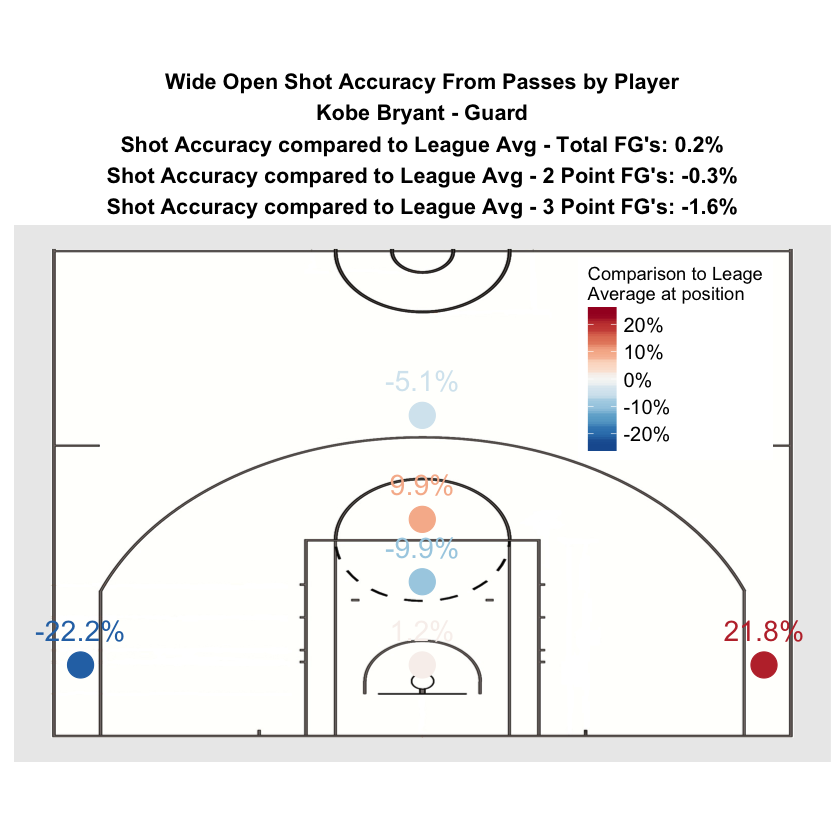

In [334]:
f_name <- "Kobe"
l_name <- "Bryant"

graph_player(f_name,l_name)
graph_player_vs_lg(f_name,l_name)

## This verifies the graph functions are working properly

In [335]:
a <- "Timofey"
b <- "Mozgov"

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

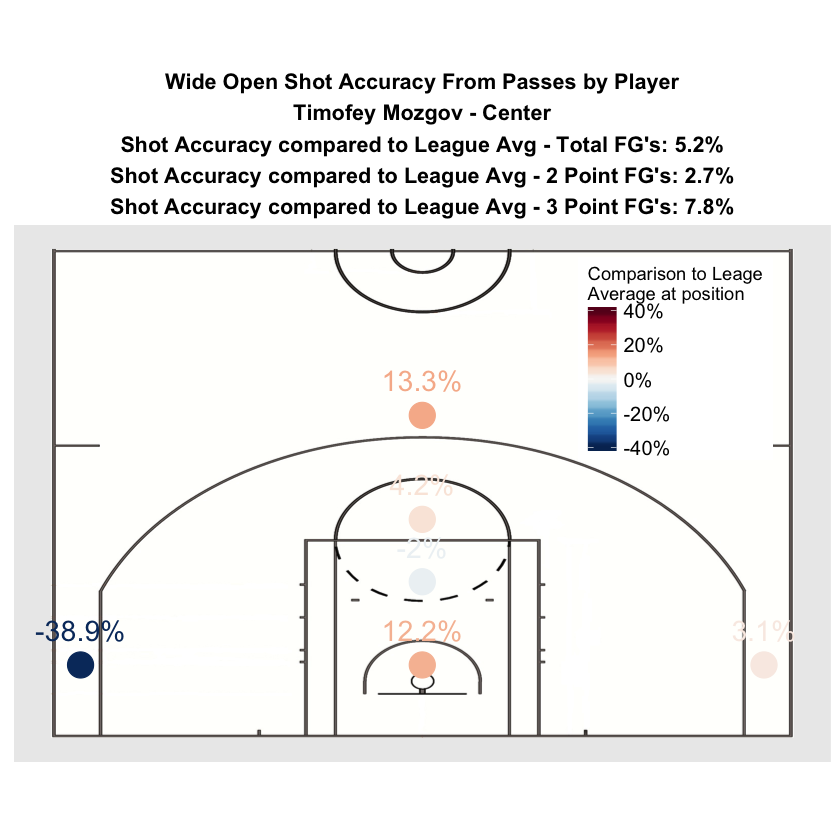

In [336]:
# get shot set for selected player
shot_set <- filter(nba_filt, !shot_zone %in% c("FT", "Beyond_Half_Court"), pass.firstname == a,
                   pass.lastname == b)

# summarise shot data
library(plyr)
shot <- ddply(shot_set, .(shot_zone), summarize, 
        SHOTS_ATTEMPTED = length(made),
        SHOTS_MADE = sum(as.numeric(as.character(made))))
        

# calculate shot zone accuracy and add zone accuracy labels
shot$SHOT_ACCURACY <- (shot$SHOTS_MADE / shot$SHOTS_ATTEMPTED)
shot$SHOT_ACCURACY_LAB <- paste(as.character(round(100 * shot$SHOT_ACCURACY, 1)), "%", sep="")



#gets league average data for player's position
pos_zone <- filter(pos_sum, 
                   pass.position == unique(shot_set$pass.position)[1]) %>% melt(id.vars = "pass.position") %>%
                   plyr::rename(c("variable" = "shot_zone", "value" = "lg_avg")) %>%
                   filter(!shot_zone %in% c("FT", "Beyond_Half_Court")) %>% mutate(ms_x = c(7,21,15,7,7,31,32,33,35),
                   ms_y = c(2,25,25,25,48,25,27,27,27))

#   gets data on specific player
player_ds <- filter(pl_avg_summary, pass.firstname == a, pass.lastname == b)

# extracts player data    
pl_all_fgs <- scales::percent(as.numeric (player_ds[5]))
pl_all_vs_avg <- scales::percent(as.numeric (player_ds[6]))

pl_all_2vs_avg <- scales::percent(as.numeric (player_ds[7]))
pl_all_3vs_avg <- scales::percent(as.numeric (player_ds[8]))

pl_2_total <- scales::percent(pos_zone[7,3] + as.numeric (player_ds[7]))
pl_3_total <- scales::percent(pos_zone[8,3] + as.numeric (player_ds[8]))

    
    
# join with league average and compute difference
shot <- left_join(shot, pos_zone[,c("shot_zone","lg_avg","ms_x","ms_y")], by = "shot_zone" ) %>% 
         mutate(VS_LG_AVG = SHOT_ACCURACY - lg_avg,
                VS_LG_AVG_LAB = paste(as.character(round(100 * VS_LG_AVG, 1)), "%", sep="")) %>%
         as.data.frame() 

# sets default color scale
clr_bound <- max(abs(shot$VS_LG_AVG))
grad_lim <- .20

# changes the color scale if there is a large value on shot chart    
if(clr_bound > grad_lim) {grad_lim = round(clr_bound +.05 ,1) }
grad_limits <- c(-grad_lim, grad_lim)

myPalette <- colorRampPalette(rev(brewer.pal(11, "RdBu")))

# plots data
ggplot(shot, aes(x=ms_y, y=ms_x)) +
    scale_colour_gradientn(colours = myPalette(100), limits=grad_limits, labels = percent, 
                           name = "Comparison to Leage\nAverage at position") +
    annotation_custom(court, 0, 50, 0, 47) +
    geom_point(aes(col = VS_LG_AVG), size = 7) +
    geom_text(aes(col = VS_LG_AVG, label = VS_LG_AVG_LAB), vjust = -1.2, size = 6) +
   guides(alpha = FALSE, size = FALSE) +
    xlim(0, 50) +
    ylim(0, 47) +
    coord_fixed(ratio = .7) +
    ggtitle(paste("Wide Open Shot Accuracy From Passes by Player\n", a," ", b, " - ",pos_zone$pass.position, 
                  "\n", "Shot Accuracy compared to League Avg - Total FG's: ", pl_all_vs_avg,
                  "\n", "Shot Accuracy compared to League Avg - 2 Point FG's: ", pl_all_2vs_avg,
                  "\n", "Shot Accuracy compared to League Avg - 3 Point FG's: ", pl_all_3vs_avg,sep = "")) +
    theme(line = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        legend.position = c(0.81, 0.75),   
        legend.title = element_text(size=11),
        legend.text=element_text(size = 12),
        plot.title = element_text(size = 13, lineheight = 1.2, face = "bold", hjust = 0.5))

In [337]:
pos_zone

pass.position,shot_zone,lg_avg,ms_x,ms_y
Center,Left_Corner_3,0.389,7,2
Center,Midrange_2,0.395,21,25
Center,Paint,0.498,15,25
Center,Restricted_Area,0.878,7,25
Center,Right_Corner_3,0.386,7,48
Center,Top_or_Wing_3,0.390,31,25
Center,two_ptrs,0.506,32,27
Center,three_ptrs,0.389,33,27
Center,all_fgs,0.443,35,27


In [338]:
shot

shot_zone,SHOTS_ATTEMPTED,SHOTS_MADE,SHOT_ACCURACY,SHOT_ACCURACY_LAB,lg_avg,ms_x,ms_y,VS_LG_AVG,VS_LG_AVG_LAB
Left_Corner_3,4,0,0.0000000,0%,0.389,7,2,-0.38900000,-38.9%
Midrange_2,16,7,0.4375000,43.8%,0.395,21,25,0.04250000,4.2%
Paint,23,11,0.4782609,47.8%,0.498,15,25,-0.01973913,-2%
Restricted_Area,6,6,1.0000000,100%,0.878,7,25,0.12200000,12.2%
Right_Corner_3,12,5,0.4166667,41.7%,0.386,7,48,0.03066667,3.1%
Top_or_Wing_3,44,23,0.5227273,52.3%,0.390,31,25,0.13272727,13.3%


## Trying out print formatting

In [340]:
g_table

Last Name,First Name,Position,# of Passes > 5ft. from Player that led to Wide Open FG Attempts,Percentage Shooting on Wide Open Shots From Passer,Comparison to League Avg FG% at Position,Comparison to League Avg FG% for 2's,Comparison to League Avg FG% for 3's
McCollum,C.J.,Guard,116,53.4%,9.0%,12.1%,6.5%
Galloway,Langston,Guard,182,52.2%,7.8%,2.6%,11.6%
Douglas,Toney,Guard,127,50.4%,6.0%,1.3%,10.8%
Felton,Raymond,Guard,543,49.7%,5.3%,6.1%,6.4%
Miller,Andre,Guard,448,49.6%,5.2%,4.3%,5.2%
Robinson,Nate,Guard,213,48.4%,4.0%,6.2%,-0.1%
Ellis,Monta,Guard,920,47.5%,3.1%,7.5%,2.5%
Vasquez,Greivis,Guard,645,47.3%,2.9%,4.5%,0.4%
Curry,Stephen,Guard,1130,47.2%,2.8%,2.8%,3.5%
Harris,Devin,Guard,400,47.0%,2.6%,9.3%,0.6%


In [342]:
install.packages("DT")

Installing package into ‘/Users/zakesk/Library/R/3.3/library’
(as ‘lib’ is unspecified)



The downloaded binary packages are in
	/var/folders/94/xf56q9b91rv4p8npfm_1bmzm0000gn/T//RtmpEuOmQv/downloaded_packages


In [345]:
library(DT) # this won't work for the HTML

In [358]:
datatable(g_table, caption = "Table 1.....", 
          options = list(columnDefs = list(list(className = 'dt-center', targets = "_all"))))

HTML widgets cannot be represented in plain text (need html)